In [ ]:
import sys
import json
import csv
import yaml
import os

# can use the following as alternative way to load a large
#    set of environment variables; see below
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import time
from datetime import datetime

import pprint

import psycopg2
from sqlalchemy import create_engine, text as sql_text

import importlib3

In [ ]:
# to add to the end of graph title
firstname = 
lastname = 
l4ID = 

In [48]:
# Load JSON data from the file
with open("3c/3c.json", 'r') as file:
    data = json.load(file)

# Printing the loaded file
print(json.dumps(data, indent=4, sort_keys=True))

{
    "update_datetimes_query_Bedford-Stuyvesant": {
        "__": {
            "avg": 10.3157,
            "count": 3,
            "max": 12.0652,
            "min": 8.7981,
            "std": 1.3438,
            "timestamp": "2025-05-17-01:27:06"
        },
        "__datetime_in_reviews__": {
            "avg": 9.2176,
            "count": 3,
            "max": 10.5104,
            "min": 8.0756,
            "std": 0.9997,
            "timestamp": "2025-05-17-01:28:02"
        },
        "__datetime_in_reviews__neigh_in_listings__": {
            "avg": 8.004,
            "count": 3,
            "max": 9.0316,
            "min": 7.1153,
            "std": 0.7885,
            "timestamp": "2025-05-17-01:29:49"
        },
        "__neigh_in_listings__": {
            "avg": 9.9471,
            "count": 3,
            "max": 11.3704,
            "min": 7.7403,
            "std": 1.5822,
            "timestamp": "2025-05-17-01:28:53"
        }
    },
    "update_datetimes_query_Bronx"

### 9. Update Datetimes Query Average Values per Location

In [49]:
records = []
location_list = []

# create a list of all the keys in the JSON file
key_labels = {
    "__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__neigh_in_listings__": "neighbourhood_index",
    "__datetime_in_reviews__neigh_in_listings__": "datetime_and_neighbourhood_index"
}

for loc_key, combos in data.items():
    # loc_key, ex. "update_datetimes_query_Bedford-Stuyvesant"
    location = loc_key.replace("update_datetimes_query_", "")

    # record the location in order
    location_list.append(location)
    row = {"location": location}
    
    # interate through combo_tag（"__", "__datetime_in_reviews__", …）
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records.append(row)

# construct DataFrame
loc_std = pd.DataFrame.from_records(records)

# rename columns by using the key_labels dictionary
loc_avg = loc_std.rename(columns=key_labels)

# set location as index
loc_avg = loc_avg.set_index("location")

print(loc_avg)


                    no_index  datetime_index  neighbourhood_index  \
location                                                            
New Springville       4.3787          1.9061               1.8647   
Fort Hamilton         2.2625          1.9407               1.9327   
Long Island City      4.4129          3.2732               3.4274   
Bedford-Stuyvesant   10.3157          9.2176               9.9471   
Staten Island         4.4184          3.9973               3.7115   
Bronx                 5.1239          4.2641               4.0419   
Queens               14.4955         15.6203              15.1944   
Manhattan            29.1600         27.5152              26.3662   

                    datetime_and_neighbourhood_index  
location                                              
New Springville                               1.9378  
Fort Hamilton                                 2.0321  
Long Island City                              3.3316  
Bedford-Stuyvesant                

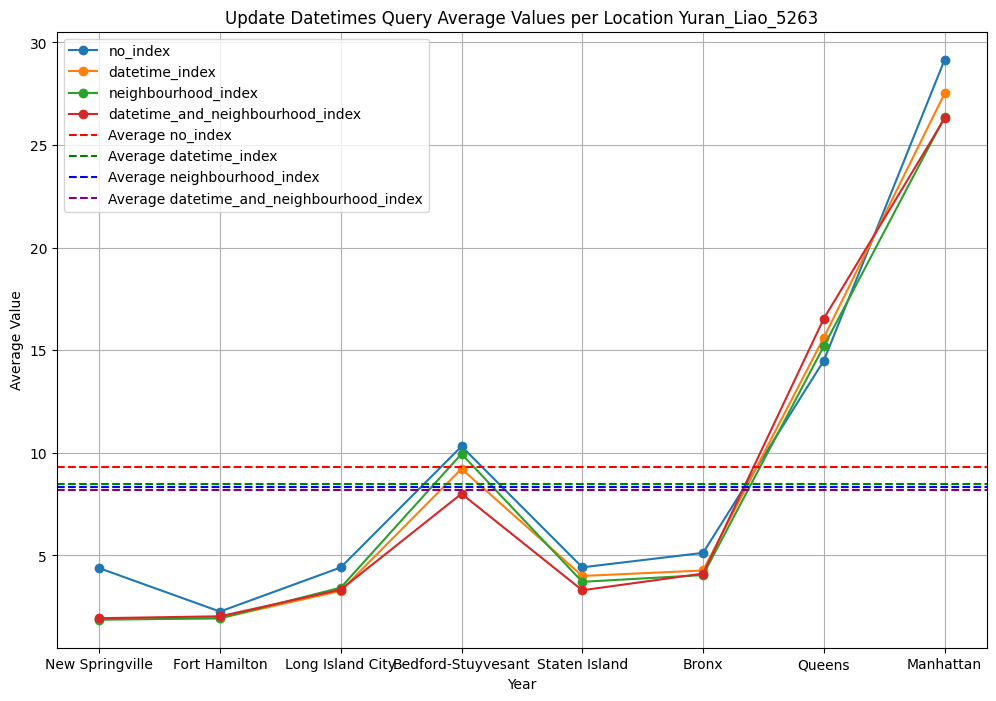

In [50]:

# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(loc_avg.index, loc_avg[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = loc_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')


plt.title(f'Update Datetimes Query Average Values per Location {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 10. Update Datetimes Query STD Values per Location

In [51]:
record_std = []

for loc_key, combos in data.items():
    # loc_key, ex. "update_datetimes_query_Bedford-Stuyvesant"
    location = loc_key.replace("update_datetimes_query_", "")

    # record the location in order
    location_list.append(location)
    row = {"location": location}
    
    # interate through combo_tag（"__", "__datetime_in_reviews__", …）
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    record_std.append(row)

# construct DataFrame
loc_std = pd.DataFrame.from_records(record_std)

# rename columns by using the key_labels dictionary
loc_std = loc_std.rename(columns=key_labels)

# set location as index
loc_std = loc_std.set_index("location")

print(loc_std)


                    no_index  datetime_index  neighbourhood_index  \
location                                                            
New Springville       3.4109          0.0260               0.0175   
Fort Hamilton         0.4540          0.0502               0.0255   
Long Island City      0.5259          0.7696               0.6757   
Bedford-Stuyvesant    1.3438          0.9997               1.5822   
Staten Island         0.5422          0.5225               0.0048   
Bronx                 0.4001          0.2116               0.2662   
Queens                1.3004          1.1375               1.1691   
Manhattan             2.1570          2.2958               2.4438   

                    datetime_and_neighbourhood_index  
location                                              
New Springville                               0.0205  
Fort Hamilton                                 0.0689  
Long Island City                              0.4740  
Bedford-Stuyvesant                

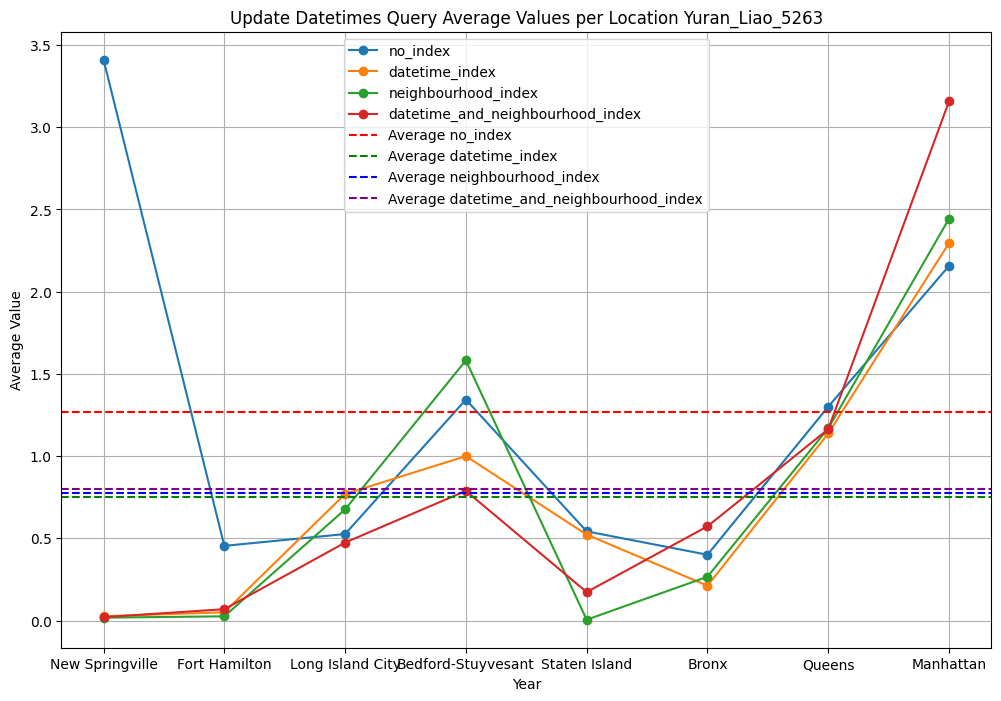

In [ ]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(loc_std.index, loc_std[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = loc_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')


plt.title(f'Update Datetimes Query STD Values per Location {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()